## About

This page showcases the work of [Octavio Medina](https://octavio.me/) in a blogpost where he shows how to build a plot to analyze the results of a regression model for an ordinal outcome. You can find the original blog post [here](https://octavio.me/posts/ordinal-viz/), written in [R](https://www.r-graph-gallery.com).

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tcapretto.netlify.app/) who translated this work from R to Python! 🙏🙏

As a teaser, here is the plot we’re gonna try building:

![scatterplot](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/graph/web-multiple-lines-and-panels.png?raw=true)


## Load libraries

Let's get started by loading the libraries that are going to be used today. As usual, we import Matplotlib for creating the visualization and NumPy to handle arrays of values. On top of that, we also use [`flexitext`](https://tomicapretto.github.io/flexitext/) to add a title with multiple styles, and the `expit` function from the `special` module in [`SciPy`](https://www.scipy.org/) to compute the probabilities you can see in the chart.


In [1]:
from functools import reduce

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from flexitext import flexitext
from scipy.special import expit

## Prepare data

Today's visualization shows the relationship between a continuous variable and an ordinal outcome (a categorical variable with more than two levels that have some intrinsic order).

It's important to remark the chart is not based on raw data. Instead, it shows the outcomes of a Bayesian ordinal regression model. These outcomes are helpful to visualize the relationship between the predictors and the outcome as well as the uncertainty in these relationships.

The following `Probabilities` class simulates the outcomes of this Bayesian model. Each call to `.compute()` returns one replicate for the four lines you see on each panel in the original chart.


In [2]:
class Probabilities:
    def __init__(self, grid, auth, responses, programs):
        self.grid = grid
        self.auth = auth
        self.responses = responses
        self.programs = programs

    def compute(self, j):
        eta = self.grid * self._auth_coef() + self._program_coef(j)
        n_responses = len(self.responses["mean"]) + 1
        probs = [0] * n_responses
        for i in range(n_responses):
            if i == 0:
                response = self._response_coef(i)
                probs[i] = expit(response - eta)
            elif i < n_responses - 1:
                response = self._response_coef(i)
                response_previous = self._response_coef(i - 1)
                probs[i] = expit(response - eta) - \
                    expit(response_previous - eta)
            else:
                probs[i] = 1 - reduce(lambda a, b: a + b, probs[:-1])

        return probs

    def _auth_coef(self):
        mean = self.auth["mean"]
        sd = self.auth["sd"]
        return np.random.normal(mean, sd)

    def _response_coef(self, idx):
        mean = self.responses["mean"][idx]
        sd = self.responses["sd"][idx]
        return np.random.normal(mean, sd)

    def _program_coef(self, idx):
        mean = self.programs["mean"][idx]
        sd = self.programs["sd"][idx]
        return np.random.normal(mean, sd)

The next step is to define some values that are going to shape the results of the simulations. If you're curious about how these parameters affect the outcomes, this is going to be fun to play with. Have a try!


In [3]:
x = np.linspace(-3, 3, 500)

auth = {
    "mean": 0.21,
    "sd": 0.06
}

responses = {
    "mean": [-0.71, 0.5, 1.28],
    "sd": [0.05] * 3
}

programs = {
    "mean": [0, 0.23, 0.39, 0.69, 0.97],
    "sd": [0] + [0.09] * 4
}

And now let's just initialize the `Probabilities` instance:


In [4]:
probabilities = Probabilities(x, auth, responses, programs)

## Basic linechart with multiple groups


Before starting to work in the chart itself, we're gonna modify the default font family. The chart we're trying to reproduce uses the **IBM Plex Sans** font that you can easily obtain from [Google Fonts](https://fonts.google.com/specimen/IBM+Plex+Sans). If you want to make sure that your custom fonts are available in Matplotlib, [there's a post](https://python-graph-gallery.com/custom-fonts-in-matplotlib) in the Galleries made just for you 😄.


In [5]:
matplotlib.rcParams["font.family"] = "IBM Plex Sans"

And the last preparation step is to obtain the colors of the lines for the groups based on the Matplotlib built-in **plasma** colormap:


In [6]:
plasma_colormap = matplotlib.cm.get_cmap("plasma")
COLORS = [plasma_colormap(x) for x in np.linspace(0.8, 0.15, num=4)]
COLORS = [matplotlib.colors.to_hex(color) for color in COLORS]

Now it's time to start working! The first thing to do is to reproduce the first panel in the chart. We need to obtain several replicates of the regression lines (100 in this case) and plot them.


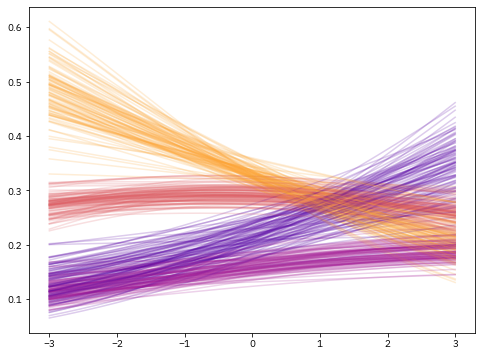

In [7]:
# Initialize chart
fig, ax = plt.subplots(figsize=(8, 6))

# Create 100 lines for each group. We don't care about the loop value, so we use the underscore.
for _ in range(100):
    # The 0 means we create values for the first panel
    probs = probabilities.compute(0)
    # Now loop over the arrays in 'y', using a different color for each group.
    for prob, color in zip(probs, COLORS):
        ax.plot(x, prob, color=color, alpha=0.2, lw=1.5)

## Customize layout

Now it's a good time to customize the layout of the chart just created above, which is a single panel of the viz we're building. This customization focuses on modifying the tick labels, adding grid lines, and setting the title.


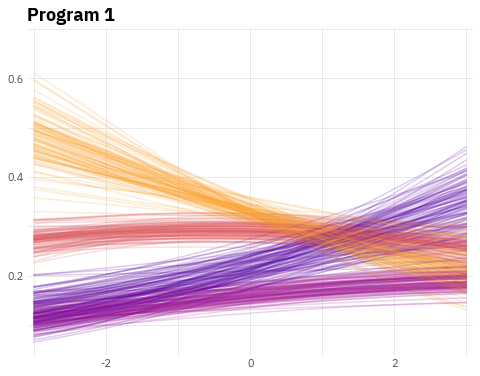

In [8]:
# Remove major and minor tick marks on both axis
ax.tick_params(axis="both", which="both", length=0)

# Set major and minor ticks for the x axis.
# These are used to draw the grid lines.
# Only the major ticks have a tick label.
ax.set_xticks([-2, 0, 2], minor=False)
ax.set_xticklabels([-2, 0, 2], minor=False, size=11, color="0.3")
ax.set_xticks([-3, -1, 1, 3], minor=True)

# Set custom limit for x axis
ax.set_xlim(-3.1, 3.1)

# Add grid lines for x axis
ax.xaxis.grid(True, which="both", color="#cccccc", alpha=0.8, lw=0.5)


# Set major and minor ticks for the y axis.
# The same logic than above.
ax.set_yticks([0.2, 0.4, 0.6], minor=False)
ax.set_yticklabels([0.2, 0.4, 0.6], minor=False, size=11, color="0.3")
ax.set_yticks([0.1, 0.3, 0.5, 0.7], minor=True)

# Add grid lines for x axis
ax.yaxis.grid(True, which="both", color="#cccccc", alpha=0.8, lw=0.5)


# Remove all the spines
for spine in ["top", "right", "bottom", "left"]:
    ax.spines[spine].set_visible(False)

# Add title
# Note this does not use the `.set_title()` method, but just a normal `.text()`
# This is to gain more control of the position.
# `transform=ax.transAxes` means the coordintes are in terms of the Axis and not the data
ax.text(0, 1.025, "Program 1", weight="bold", size=18, transform=ax.transAxes)

fig

## Multiple panels plot

It's time to extend the previous work to multiple panels (multiple Programs in the modeling problem). Before doing that, it's better to define a function that adjusts the layout of the axis so the code that produces the plot is clearer.


In [9]:
# This function is basically the code we wrote in the chunk above
def adjust_axis_layout(ax, title):
    ax.tick_params(axis="both", which="both", length=0)

    ax.set_xticks([-2, 0, 2], minor=False)
    ax.set_xticklabels([-2, 0, 2], minor=False, size=11, color="0.3")
    ax.set_xticks([-3, -1, 1, 3], minor=True)
    ax.set_xlim(-3.1, 3.1)
    ax.xaxis.grid(True, which="both", color="#cccccc", alpha=0.8, lw=0.5)

    ax.set_yticks([0.2, 0.4, 0.6], minor=False)
    ax.set_yticklabels([0.2, 0.4, 0.6], minor=False, size=11, color="0.3")
    ax.set_yticks([0.1, 0.3, 0.5, 0.7], minor=True)
    ax.yaxis.grid(True, which="both", color="#cccccc", alpha=0.8, lw=0.5)

    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)

    ax.set_title(title, weight=500, size=14, loc="left")

    return ax

Below is where the magic is happening. It looks like a short chunk of code, but actually a lot is going on. And the result is so beautiful!


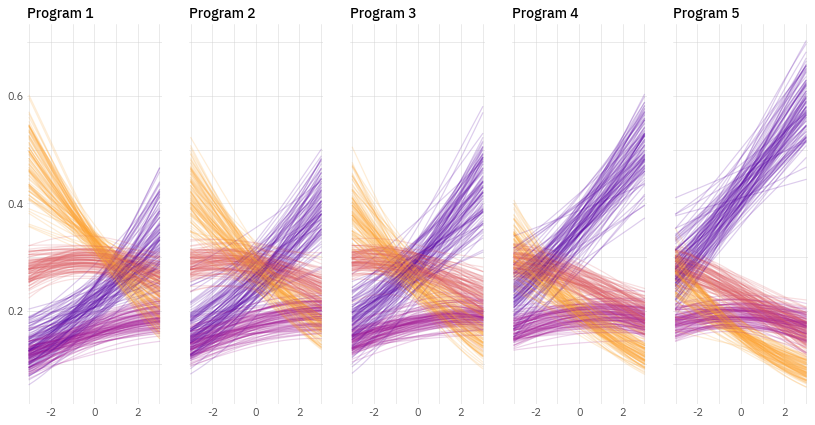

In [10]:
# Initialize layout. Note we're using 1 row and 5 columns.
fig, axes = plt.subplots(1, 5, figsize=(14, 7), sharey=True)

# Set figure background color
fig.set_facecolor("white")

# Iterate over panels (programs)
for j in range(5):
    # Select axis corresponding to the program
    ax = axes[j]
    # Create 100 replicates for each group
    for _ in range(100):
        probs = probabilities.compute(j)
        for prob, color in zip(probs, COLORS):
            ax.plot(x, prob, color=color, alpha=0.2, lw=1.2)

    # Note the title is unique for each panel/program
    adjust_axis_layout(ax, f"Program {j + 1}")

## Add title with multiple styles

The title plays a crucial role in this chart. It gives an insightful description of what is seen in the chart and information about the groups by identifying each of them with a color in the description below.

We use the `flexitext` function from the `flexitext` library to add text with multiple formats as title. Formats are specified using a tag based system that you can review in the [package documentation](https://tomicapretto.github.io/flexitext/).


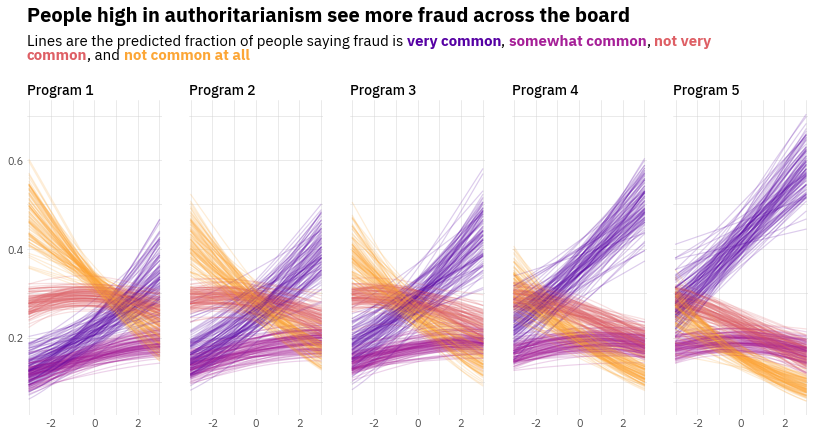

In [11]:
# Make room for the title on the top of the figure
fig.subplots_adjust(top=0.75)

# Create formatted string that is going to be passed to flexitext()
title = (
    "<size:20, weight:bold>People high in authoritarianism see more fraud across the board</>\n\n"
    "<size:15>Lines are the predicted fraction of people saying fraud is "
    f"<color:{COLORS[3]}, weight:bold>very common</>, <color:{COLORS[2]}, weight:bold>somewhat common</>, "
    f"<color:{COLORS[1]}, weight:bold>not very\ncommon</>, and <color:{COLORS[0]}, weight:bold>not common at all</></>"
)

# Add text with flexitext()
# xycoords="figure fraction" means the coordinates we pass (x=0.125 and y=0.825)
# are specified in terms of the figure, not the axis.
flexitext(0.125, 0.825, title, va="bottom",
          xycoords="figure fraction", ax=axes[0])
fig

## Add final annotations

The chart is very close to the original one. This last step consists of adding text annotations on the right side of the figure that are helpful to communicate which color corresponds to which category of the ordinal response variable.


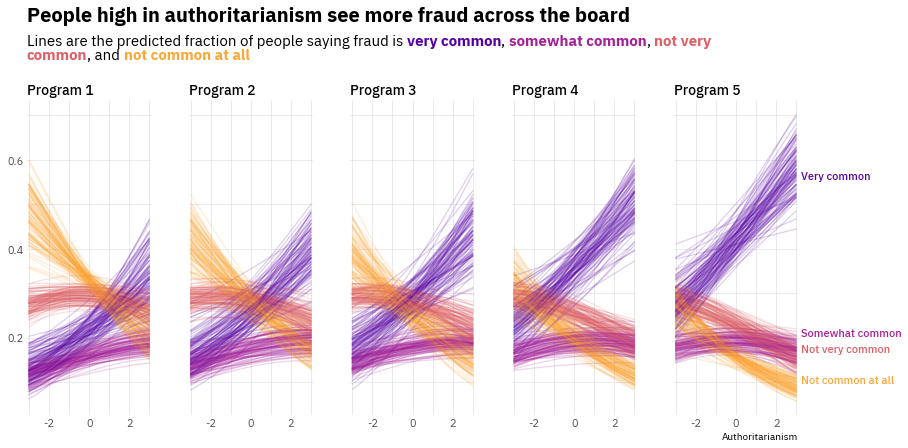

In [12]:
# Make room on the right side of the figure and adjust the horizontal space between axes
fig.subplots_adjust(right=0.89, wspace=0.3)

# Select the last Axis (the rightmost one)
ax = axes[-1]

# Manually, add the labels
ax.text(
    1.02, 0.75, "Very common", size=11, weight="medium",
    color=COLORS[3], transform=ax.transAxes
)
ax.text(
    1.02, 0.25, "Somewhat common", size=11, weight="medium",
    color=COLORS[2], transform=ax.transAxes
)
ax.text(
    1.02, 0.2, "Not very common", size=11, weight="medium",
    color=COLORS[1], transform=ax.transAxes
)
ax.text(
    1.02, 0.1, "Not common at all", size=11, weight="medium",
    color=COLORS[0], transform=ax.transAxes
)

ax.text(1, -0.075, "Authoritarianism", ha="right",
        size=10, transform=ax.transAxes)

# fig.savefig("plot.png", dpi=300) # if you want to save it

fig

We did it! Doesn't it seem like something one should be proud of? 😎
